## Enviroment Setup

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'utils')))

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from plotnine import *
from IPython.display import HTML
from utils.helper_funcs import *
import pickle as pkl
from fairlearn.reductions import ExponentiatedGradient

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.utils.validation") # ignore warnings about feature names

### 1 - Preprocess afib data

In [ ]:
%run utils/afib.py

### 2 - Train Models

In [ ]:
%run utils/train_models.py

Model Performance Report

In [3]:
results = []
for dataset_name in ['UTI', 'AFIB', 'COMPAS']:
# for dataset_name in ['UTI']:

    X_train, X_test, y_train, y_test = load_train_test(dataset_name, 0)
    for fair in [0,1]:        
        models = load_models(dataset_name, fair)
        for model_name, model in models.items():
            # if model_name == "Neural Network":
            #     preds_prob = model.predict_proba(X_test).squeeze().cpu().numpy()
            #     preds = model.predict(X_test).squeeze().cpu().numpy()
            # else:
            preds_prob = np.array([])
            if isinstance(model, ExponentiatedGradient):
                preds_prob = expgrad_predict_proba(model, X_test)[:, 1]
            else:
                preds_prob = model.predict_proba(X_test)[:, 1]
            preds = model.predict(X_test)

            # Compute metrics
            acc = accuracy_score(y_test, preds)
            precision = precision_score(y_test, preds)
            recall = recall_score(y_test, preds)
            f1 = f1_score(y_test, preds)
            auc = roc_auc_score(y_test, preds_prob)

            results.append({
                "Model": model_name,
                "Dataset": dataset_name,
                "fair": bool(fair),
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "ROC AUC": auc
            })


# Step 2: Convert to DataFrame
df = pd.DataFrame(results)

# Step 3: Map fair boolean to 'baseline'/'fair'
df['fair_label'] = df['fair'].map({False: 'Baseline', True: 'Fair'})

# Step 4: Melt the metrics to long format
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
df_melted = df.melt(
    id_vars=['Model', 'Dataset', 'fair_label'],
    value_vars=metrics,
    var_name='Metric',
    value_name='Value'
)

# Step 5: Pivot the table to get desired MultiIndex layout
result = df_melted.pivot_table(
    index=['Model', 'Metric'],
    columns=['Dataset', 'fair_label'],
    values='Value'
)

# Optional: Sort for readability
result = result.round(4)

# Step 6: Display
latex_table = result.to_latex(multicolumn=True, multirow=True)
result[['UTI', 'AFIB', 'COMPAS']]

Dataset                            UTI             AFIB           COMPAS  \
fair_label                    Baseline    Fair Baseline    Fair Baseline   
Model               Metric                                                 
Logistic Regression Accuracy    0.7313  0.6512   0.6844  0.6844   0.7452   
                    F1          0.5667  0.5018   0.6901  0.6916   0.7005   
                    Precision   0.6667  0.5113   0.6731  0.6716   0.7421   
                    ROC AUC     0.7816  0.7430   0.7404  0.7399   0.8244   
                    Recall      0.4928  0.4928   0.7080  0.7128   0.6634   
Neural Network      Accuracy    0.7571  0.6460   0.9923  0.9938   0.7428   
                    F1          0.6083  0.0420   0.9923  0.9938   0.6946   
                    Precision   0.7157  0.6000   0.9847  0.9877   0.7441   
                    ROC AUC     0.7724  0.6502   0.9998  1.0000   0.8208   
                    Recall      0.5290  0.0217   1.0000  1.0000   0.6514   
Random Forest       Accuracy    0.7132  0.6925   0.9886  0.9883   0.7496   
                    F1          0.6288  0.5882   0.9884  0.9881   0.7144   
                    Precision   0.5839  0.5629   1.0000  1.0000   0.7325   
                    ROC AUC     0.7859  0.7641   0.9993  0.9994   0.8239   
                    Recall      0.6812  0.6159   0.9770  0.9765   0.6973   
XGBoost             Accuracy    0.7519  0.6537   0.9896  0.9896   0.7472   
                    F1          0.5714  0.4553   0.9894  0.9894   0.6958   
                    Precision   0.7442  0.5185   0.9997  0.9997   0.7571   
                    ROC AUC     0.7887  0.7322   0.9956  0.9956   0.8241   
                    Recall      0.4638  0.4058   0.9793  0.9793   0.6437   

Dataset                                
fair_label                       Fair  
Model               Metric             
Logistic Regression Accuracy   0.7437  
                    F1         0.7024  
                    Precision  0.7342  
                    ROC AUC    0.8114  
                    Recall     0.6732  
Neural Network      Accuracy   0.6657  
                    F1         0.5900  
                    Precision  0.6568  
                    ROC AUC    0.7951  
                    Recall     0.5355  
Random Forest       Accuracy   0.7300  
                    F1         0.6995  
                    Precision  0.6995  
                    ROC AUC    0.8179  
                    Recall     0.6995  
XGBoost             Accuracy   0.7339  
                    F1         0.6948  
                    Precision  0.7166  
                    ROC AUC    0.8178  
                    Recall     0.6743

### 3 - SHAP Computation

In [4]:
results = evaluate_models(['UTI', 'AFIB', 'COMPAS'])

Calculating SHAP values for UTI...
Processing model: Logistic Regression


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/39 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/39 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/39 [00:00<?, ?it/s]

Completed: Neural Network
Processing model: Logistic Regression


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Neural Network
Calculating SHAP values for AFIB...
Processing model: Logistic Regression


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/1596 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/1596 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/1596 [00:00<?, ?it/s]

Completed: Neural Network
Processing model: Logistic Regression


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Neural Network
Calculating SHAP values for COMPAS...
Processing model: Logistic Regression


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/204 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/204 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/204 [00:00<?, ?it/s]

Completed: Neural Network
Processing model: Logistic Regression


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Neural Network


In [13]:
with open('output/results_test.pkl', 'wb') as f:
    pkl.dump(results, f)


In [123]:
with open('output/results_test.pkl', 'rb') as f:
    results = pkl.load(f)

## Results

### Fairness of Models

0.5362177929022849
0.076746609300684
0.4009052256206282
   Dataset   Fairness                Model       EOD
0      UTI   Baseline  Logistic Regression  0.293632
1      UTI   Baseline        Random Forest  0.374332
2      UTI   Baseline              XGBoost  0.461838
3      UTI   Baseline       Neural Network  0.536218
4      UTI  Mitigated  Logistic Regression  0.080467
5      UTI  Mitigated        Random Forest  0.150219
6      UTI  Mitigated              XGBoost  0.044533
7      UTI  Mitigated       Neural Network  0.033058
8     AFIB   Baseline  Logistic Regression  0.076747
9     AFIB   Baseline        Random Forest  0.001993
10    AFIB   Baseline              XGBoost  0.004004
11    AFIB   Baseline       Neural Network  0.040432
12    AFIB  Mitigated  Logistic Regression  0.051673
13    AFIB  Mitigated        Random Forest  0.002124
14    AFIB  Mitigated              XGBoost  0.004004
15    AFIB  Mitigated       Neural Network  0.009756
16  COMPAS   Baseline  Logistic Regression 

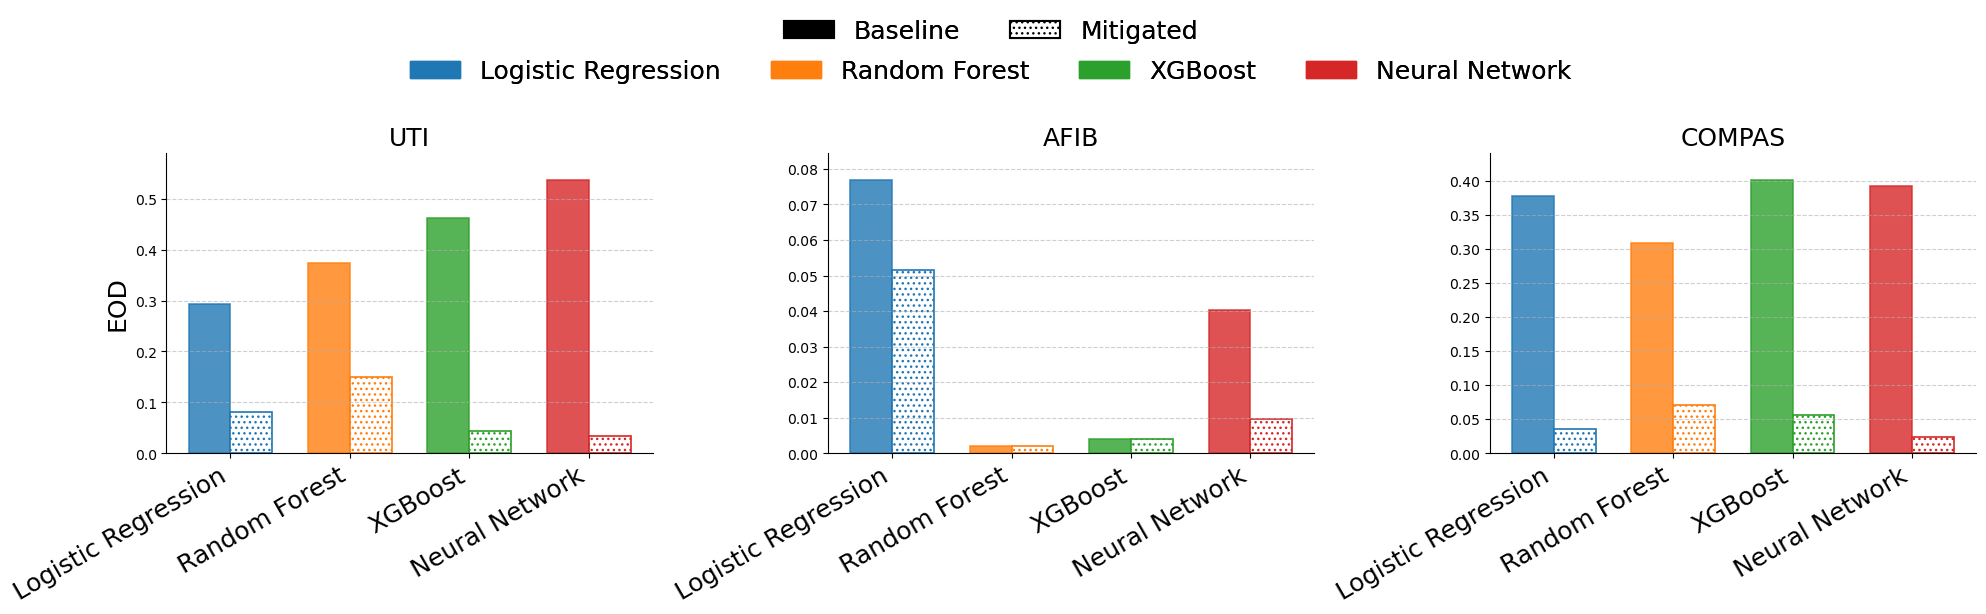

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

fontsize = 18

# Sample df creation for demonstration (replace this with your actual df)
rows = []

for dataset in results.keys():
    for fairness_type in results[dataset]['EOD'].keys():
        for i, model in enumerate(results['UTI']['shap_values'][0].keys()):
            rows.append({
                'Dataset': dataset,
                'Fairness': fairness_type,
                'Model': model,
                'EOD': results[dataset]['EOD'][fairness_type][i]
            })

df = pd.DataFrame(rows)

datasets = df['Dataset'].unique()
models = df['Model'].unique()

# Assign colors to models for consistency
model_colors = {
    'Logistic Regression': '#1f77b4',
    'Random Forest': '#ff7f0e',
    'XGBoost': '#2ca02c',
    'Neural Network': '#d62728'
}

hatch_pattern = '...'

fig, axs = plt.subplots(1, len(datasets), figsize=(20, 5), sharey=False)

for i, dataset in enumerate(datasets):
    ax = axs[i]
    df_ds = df[df['Dataset'] == dataset]
    
    x = np.arange(len(models))
    
    baseline_vals = [df_ds[(df_ds['Model'] == m) & (df_ds['Fairness'] == 'Baseline')]['EOD'].values[0] for m in models]
    mitigated_vals = [df_ds[(df_ds['Model'] == m) & (df_ds['Fairness'] == 'Mitigated')]['EOD'].values[0] for m in models]

    bar_width = 0.35  # width of individual bars
    x = np.arange(len(models))  # base x locations for models
    
    # Plot baseline bars slightly to the left
    bars1 = ax.bar(
        x - bar_width / 2,
        baseline_vals,
        width=bar_width,
        color=[model_colors[m] for m in models],
        edgecolor=[model_colors[m] for m in models],
        label='Baseline',
        alpha=0.8,
        linewidth=1.2
    )

    # Plot mitigated bars slightly to the right
    bars2 = ax.bar(
        x + bar_width / 2,
        mitigated_vals,
        width=bar_width,
        color='white',
        edgecolor=[model_colors[m] for m in models],
        hatch='...',
        label='Mitigated',
        linewidth=1.2
    )
    
    ax.set_title(dataset, fontsize=fontsize)
    ax.set_xticks(x)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(dataset, fontsize=fontsize)
    ax.set_xticklabels(models, rotation=30, ha='right', fontsize=fontsize)
    ax.set_ylim(0, max(baseline_vals + mitigated_vals) * 1.1)  # 10% headroom

    print(max(baseline_vals + mitigated_vals))

    if i == 0:
        ax.set_ylabel('EOD', fontsize=fontsize)

# Create custom legend entries

# Fairness legend (black & white)
fairness_patches = [
    Patch(facecolor='black', edgecolor='black', label='Baseline', linewidth=1.5),
    Patch(facecolor='white', edgecolor='black', hatch=hatch_pattern, label='Mitigated', linewidth=1.5)
]

# Model legend (colors only)
model_patches = [Patch(facecolor=color, edgecolor=color, label=model) for model, color in model_colors.items()]

# Draw fairness legend first, then model legend below by calling fig.legend twice

# First fairness legend — centered below the plots, few columns
leg1 = fig.legend(
    handles=fairness_patches,
    loc='lower center',
    ncol=2,
    fontsize=fontsize,
    frameon=False,
    bbox_to_anchor=(0.5, 1),
    borderaxespad=0.
)

# Second model legend — centered below the fairness legend
leg2 = fig.legend(
    handles=model_patches,
    loc='lower center',
    ncol=4,
    fontsize=fontsize,
    frameon=False,
    bbox_to_anchor=(0.5, .92),
    borderaxespad=0.
)

# Add legends manually to the figure so they show both
fig.add_artist(leg1)
fig.add_artist(leg2)




plt.tight_layout(rect=[0, 0.1, 1, 1])

fig.subplots_adjust(top=0.8, bottom=0.2)  # leave more space around for legends
plt.savefig('output/eod_results.pdf',bbox_inches='tight')  # 300 dpi for print-quality
print(df)
plt.show()

In [44]:
import shap
import seaborn as sns
shap.__version__

'0.48.0'

In [43]:
!pip install seaborn

### Export plots for SHAP differences

In [123]:

def process_dataset_results(dataset_results, PRINT=False):
    def format_df(df, cohort):
        p_values_b, p_values_o =  df.groupby(cohort).apply(wilcoxon_across_df)

        df_formatted = df.groupby(cohort).mean()
        for col in df_formatted.columns:
            p_val_row = [p_values_b[col], p_values_o[col]]
            
            df_formatted[col] = [f"<b>{v:.4f}<br>({p_val:.4f})</b>" if p_val < 0.01 else f"{v:.4f}<br>({p_val:.4f})" for v, p_val in zip(df_formatted[col], p_val_row)]

        return df_formatted

    # call data by value not reference
    temp_data_results = deepcopy(dataset_results['shap_values'])
    temp_data = deepcopy(dataset_results['shap_data'])
    temp_data[0].loc[:,'race'] = ["Black" if int(race)==1 else "Other" for race in temp_data[0]['race']] # add labels to race variable
    # temp_data[1].loc[:,'race'] = ["Black" if int(race)==1 else "Other" for race in temp_data[1]['race']] # add labels to race variable

    index_tuples = []
    processed_results = pd.DataFrame()
    processed_results_formatted = pd.DataFrame()

    for model in list(temp_data_results[0].keys()):
        index_tuples.append((model, 'Black'))
        index_tuples.append((model, 'Other'))
        temp = pd.DataFrame(temp_data_results[1][model]-temp_data_results[0][model], columns=temp_data[0].columns.values)
        
        groupd_df = temp.groupby(temp_data[0]['race']).mean() # use base data race information over transformed data
        grouped_df_formatted = format_df(temp, temp_data[0]['race'])

        processed_results = pd.concat([processed_results, groupd_df])
        processed_results_formatted = pd.concat([processed_results_formatted, grouped_df_formatted])

    processed_index = pd.MultiIndex.from_tuples(
        index_tuples,
        names=['Model', 'Race']
    )

    processed_results.index = processed_index
    processed_results_formatted.index = processed_index

    if PRINT:
        return HTML(processed_results_formatted.to_html(escape=0))
    else:
        return processed_results, processed_results_formatted, temp_data



def plot_results_matplotlib(df, dataset_name):
    # --- Ensure MultiIndex with correct names ---
    if 'Model' in df.columns and 'Race' in df.columns:
        df = df.set_index(['Model', 'Race'])
    if df.index.names != ['Model', 'Race']:
        df.index.set_names(['Model', 'Race'], inplace=True)

    # --- Config ---
    fontsize = 16
    hatch_pattern = '///'
    alpha_fill = 0.3  # light fill for bars

    races = df.index.get_level_values('Race').unique()
    models = df.index.get_level_values('Model').unique()
    bar_width = 0.35

    # --- Plot ---
    fig, axs = plt.subplots(1, len(models), figsize=(24, 6), sharey=False)
    for i, model in enumerate(models):
        ax = axs[i]
        df_m = df.loc[model]  # Subset for this model (index = Race, columns = features)

        # Compute mean absolute SHAP diff per feature
        feature_importance = df_m.abs().mean(axis=0).sort_values(ascending=False)

        # Select top 5 features, skipping duplicates based on base name
        top_n = 5
        selected_bases = set()
        top_features = []

        for col in feature_importance.index:
            base = col.split('_')[0]  # treat everything before '_' as base feature
            if base not in selected_bases:
                selected_bases.add(base)
                top_features.append(col)
            if len(top_features) >= top_n:
                break

        df_top = df_m[top_features]
        x = np.arange(len(top_features))

        for j, race in enumerate(races):
            offset = (j - (len(races)-1)/2) * bar_width  # center bars
            vals = df_top.loc[race].values

            for k, val in enumerate(vals):
                color_edge = '#2ca02c' if val >= 0 else '#d62728'  # outline color
                color_fill = color_edge  # same color for fill, but light

                ax.barh(
                    x[k] + offset,
                    val,
                    height=bar_width,
                    facecolor=color_fill,
                    alpha=alpha_fill,
                    edgecolor='black',
                    hatch=hatch_pattern if j != 0 else None,
                    linewidth=1.5,
                )
        # Y-axis labels only on the first subplot
        ax.set_yticks(x)
        if i == 0:
            # Suppose top_features is your list of y-axis labels
            y_labels = []
            for label in top_features:
                if '(' in label:
                    # Split at the first '(' and add it back on the next line
                    parts = label.split('(', 1)
                    new_label = parts[0] + '\n(' + parts[1]
                    y_labels.append(new_label)
                else:
                    y_labels.append(label)

            ax.set_yticklabels(y_labels, fontsize=fontsize)
            # ax.set_yticklabels(top_features, fontsize=fontsize)
            # ax.set_ylabel('Top Features', fontsize=fontsize)
        else:
            ax.set_yticklabels([])

        ax.set_xlabel('', fontsize=fontsize)
        ax.set_title(model, fontsize=fontsize+2)
        ax.axvline(0, color='black', linewidth=1)
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # --- Legends ---
    green_rgba = (0.176, 0.631, 0.263, alpha_fill)  # green with alpha
    red_rgba = (0.843, 0.157, 0.157, alpha_fill)    # red with alpha
    race_patches = [
        Patch(facecolor='white', edgecolor='black', label=races[0], linewidth=1.5),
        Patch(facecolor='white', edgecolor='black', hatch=hatch_pattern, label=races[1], linewidth=1.5)
    ]

    sign_patches = [
        Patch(facecolor=green_rgba, edgecolor=green_rgba, label='Positive', linewidth=1.5),
        Patch(facecolor=red_rgba, edgecolor=red_rgba, label='Negative', linewidth=1.5)
    ]

    # Race legend
    leg1 = fig.legend(
        handles=race_patches,
        loc='lower center',
        ncol=2,
        fontsize=fontsize,
        frameon=False,
        bbox_to_anchor=(0.5, 1),
        borderaxespad=0.
    )

    # Sign legend
    leg2 = fig.legend(
        handles=sign_patches,
        loc='lower center',
        ncol=2,
        fontsize=fontsize,
        frameon=False,
        bbox_to_anchor=(0.5, .92),
        borderaxespad=0.
    )


    fig.add_artist(leg1)
    fig.add_artist(leg2)

    fig.text(
        0.5,       # x-coordinate (center)
        0.05,      # y-coordinate (bottom margin)
        'SHAP Difference ($\phi(f_{mitigated},x) − \phi(f_{Basline}, x$))',  # label text
        ha='center',
        fontsize=fontsize
    )

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    fig.subplots_adjust(top=0.8, bottom=0.2)

    return fig

<>:177: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_119790/2328123830.py:177: SyntaxWarning: invalid escape sequence '\p'


/tmp/ipykernel_119790/2328123830.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Other', 'Black', 'Other', 'Other', 'Black', 'Black', 'Black', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Black', 'Black', 'Black', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Black', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Black', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Black', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Oth

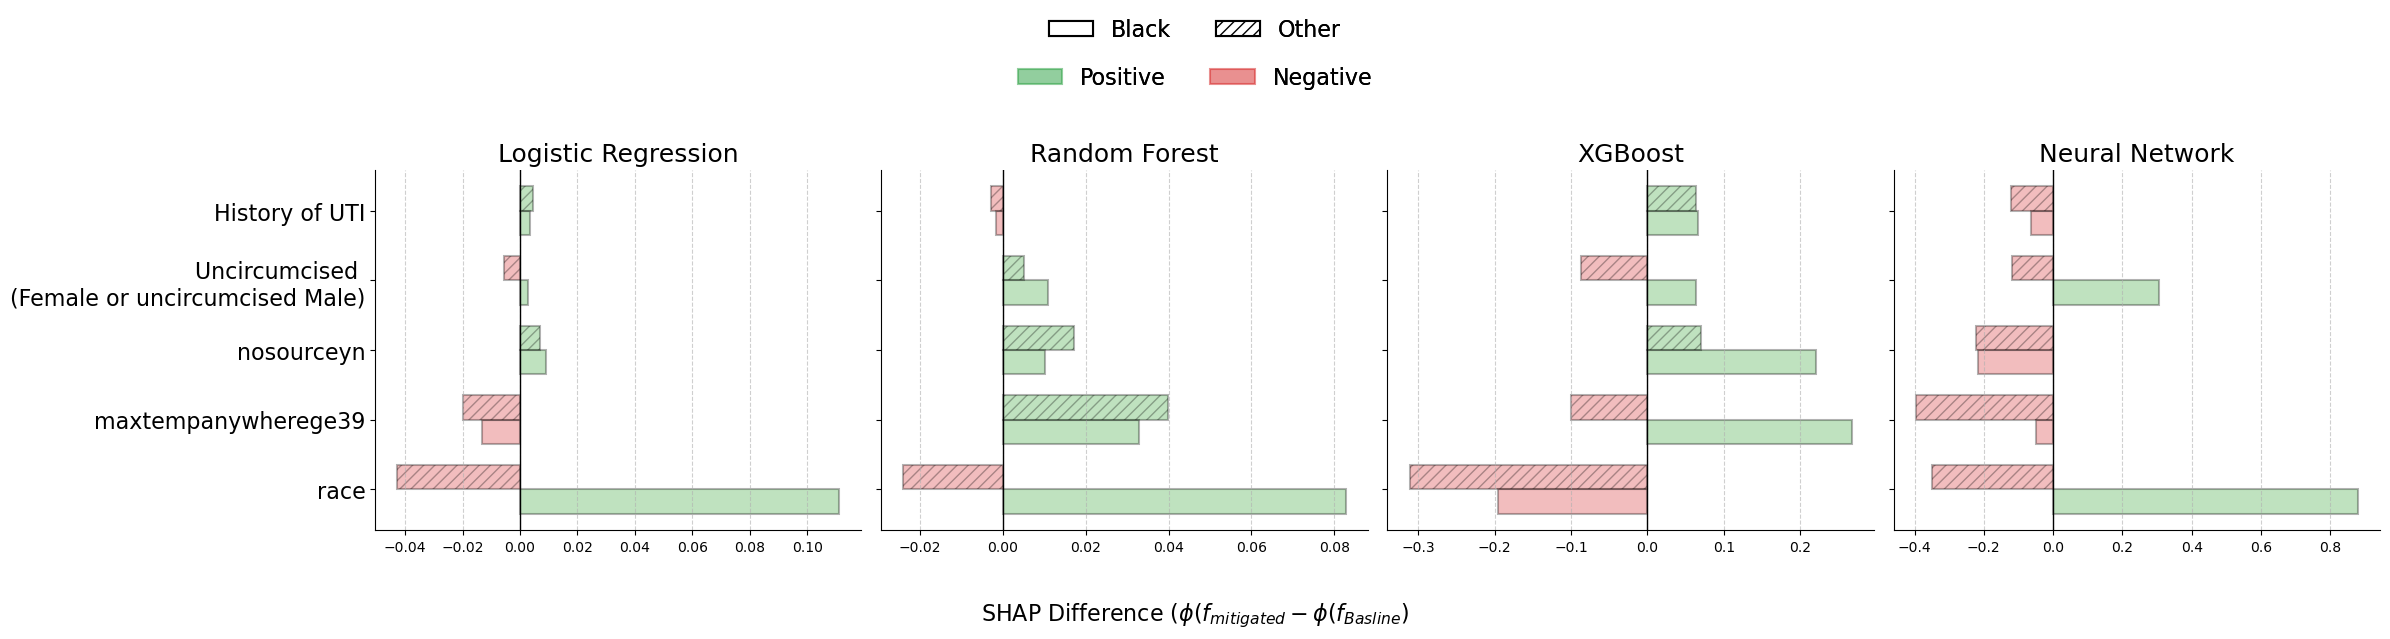

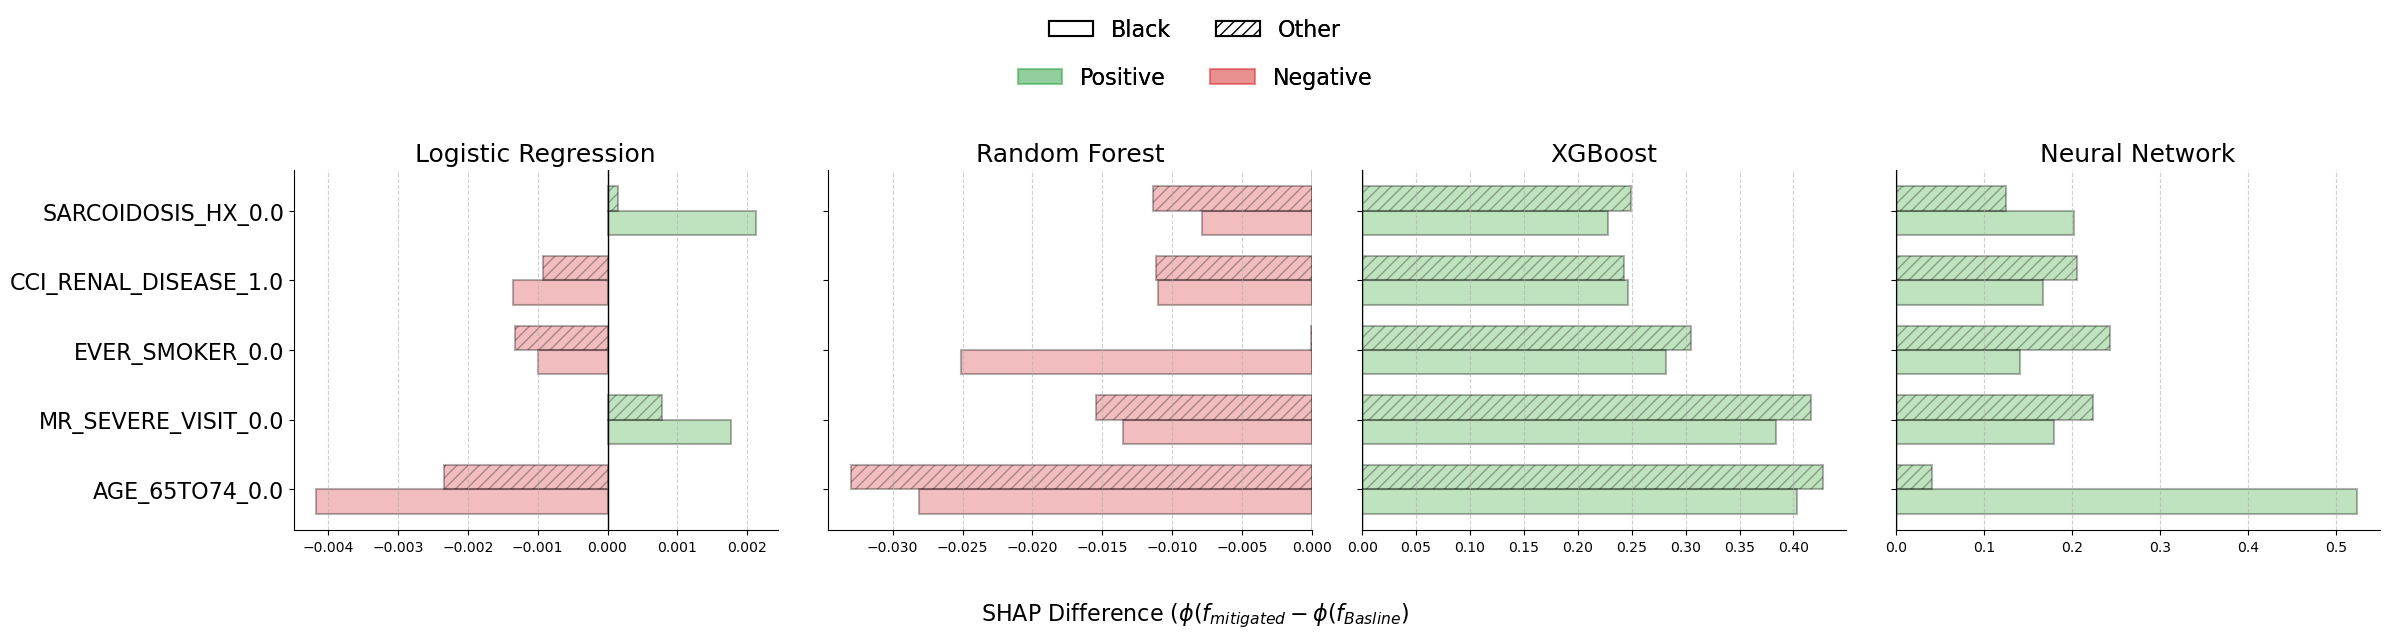

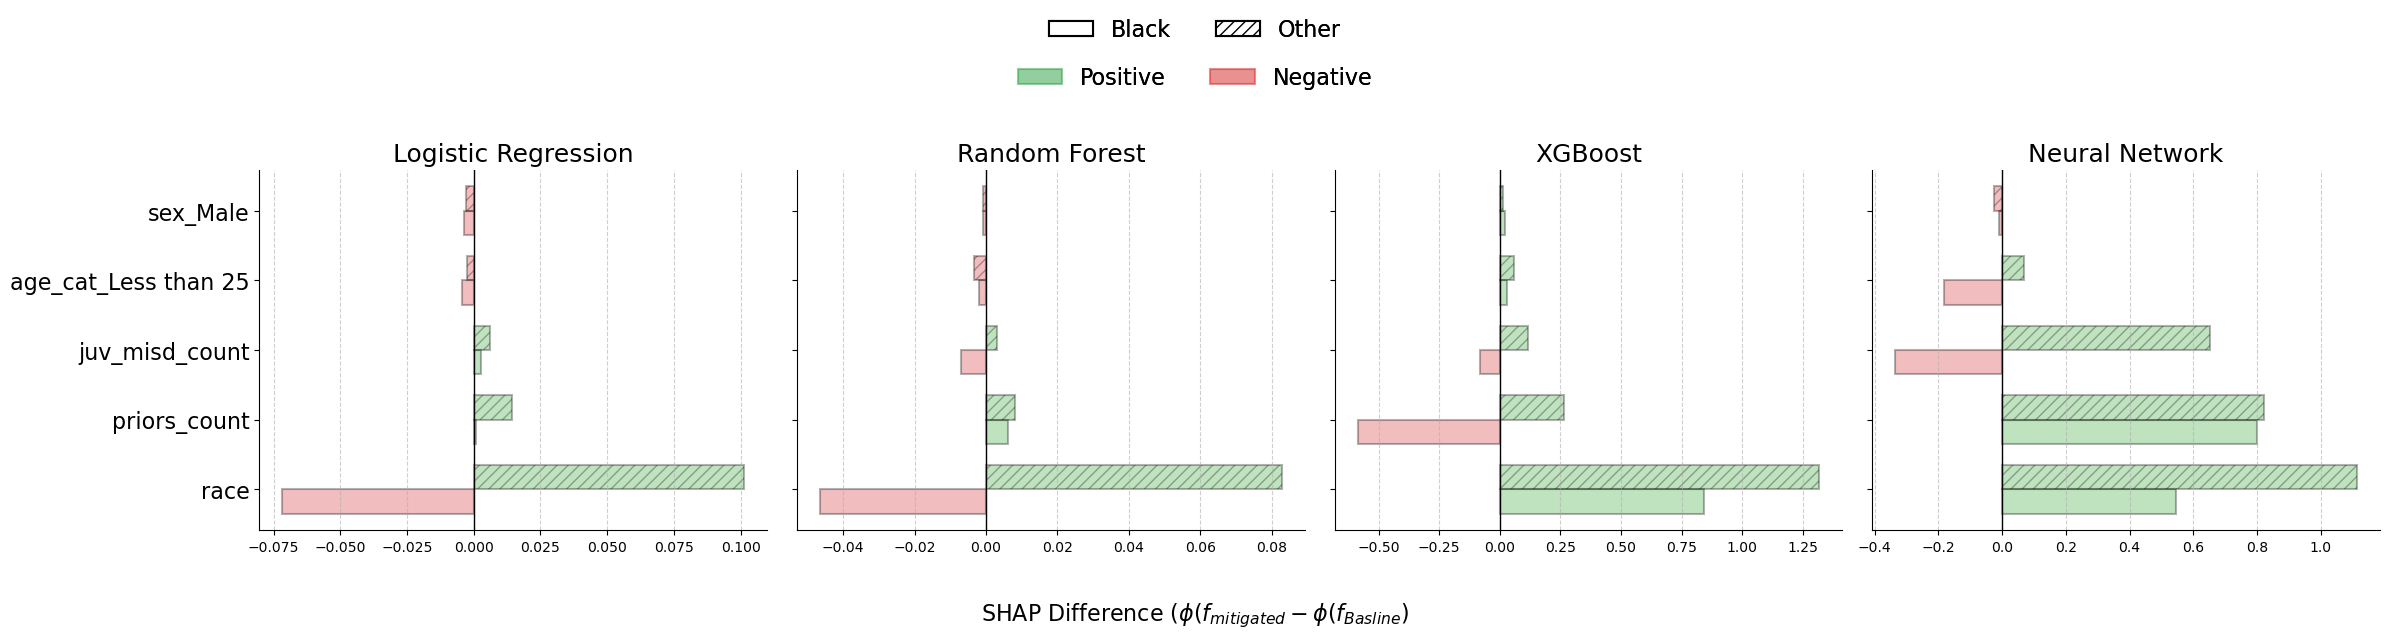

In [124]:
tables = []
plots = []
for dataset in results.keys():
    result_data, _, cohort = process_dataset_results(results[dataset], PRINT=0)
    tables.append(_)
    
    # result_
    # plot = plot_results(result_data, dataset)
    # ggsave(plot, f"output/result_plot_{dataset}.png", width=10, height=5, dpi=300)
    fig = plot_results_matplotlib(result_data, dataset)

    # Option 1: Show it
    fig.show()

    # Option 2: Save it
    fig.savefig(f"output/{dataset}_SHAP_diff.png", dpi=300, bbox_inches="tight")

In [ ]:
HTML(tables[0].to_html(escape=0))

In [ ]:
HTML(tables[1].to_html(escape=0))

In [ ]:
HTML(tables[2].to_html(escape=0))